# This notebook file is used aligning fitbit for the PA protocol

In [2]:
import pandas as pd
from datetime import datetime, time, timedelta
from matplotlib import pyplot as plt

## The block of code below reads in the fitbit-hr, fitabase and actiheart data. Then it plots them
<p>Please be sure to change the first line of code in the block below. You should change the participant number to the current participant that you are trying to process. For example the end of the line may read something like '\\2989\\'. If you wanted to process participant 3000 you would change the 2989 to 3000.</p>

In [3]:
path = "V:\\ACOI\\R01 - W4K\\3_PA protocol\\1_Participants\\3499\\" #### CHANGE THE END OF THIS LINE OF CODE TO THE PARTICIPANT
part_id = path[-5:-1]
part_id

'3499'

In [4]:
# Read in tracking sheet to obtain protocol date
tracking_sheet = pd.read_excel("V:\\ACOI\\R01 - W4K\\3_PA protocol\\PA master tracking.xlsx").dropna(how='all')
tracking_sheet
date = tracking_sheet.loc[tracking_sheet['WDID'] == int(part_id), 'PROTOCOL DATE'].iloc[0]
# Read in activity log to obtain protocl start and end
activity_log = pd.read_excel(path + "Survey and Protocol documents\\Activity time log.xlsx", usecols=['Activity', 'Start time', 'End time'])
start = datetime.combine(date.date(), activity_log.iloc[0,1])
end = datetime.combine(date.date(), activity_log.iloc[-1,2])
print(f"Protocol Start: {start} \nProtocol End: {end}")

Protocol Start: 2024-01-22 15:42:45 
Protocol End: 2024-01-22 16:48:08


In [21]:
# Read in FITBIT data
slog_hr = pd.read_csv(path + "Fitbit data\\" + part_id + "_heart.csv", parse_dates=['Time'], infer_datetime_format=True)
# Read in FITABASE data
fitabase = pd.read_csv(path + "Fitbit data\\Fitabase\\" + part_id + "_hr.csv", parse_dates=['Time'])
# Select data corresponding to protocol
fitabase = fitabase.loc[(fitabase['Time'] >= start) & (fitabase['Time'] <= end), :].reset_index(drop=True)
garmin = pd.read_csv(path + "Garmin data\\" + part_id + "_1_raw_data.csv", parse_dates=['record.timestamp[s]'], infer_datetime_format=True)

garmin_date = datetime(year=1989, month=12, day=31)

# Convert epoch time to datetime
garmin['record.timestamp[s]'] = pd.to_datetime(garmin['record.timestamp[s]'], unit='s', origin='unix')

# Add the number of seconds since 'garmin_date'
garmin['record.timestamp[s]'] = garmin['record.timestamp[s]'] + (garmin_date - datetime(1970, 1, 1))
garmin['record.timestamp[s]'] = garmin['record.timestamp[s]'] + pd.Timedelta(days=14, hours=21, minutes=50, seconds=0)

# Create a mask for the time range
mask = (garmin['record.timestamp[s]'] >= start + timedelta(minutes=8)) & (garmin['record.timestamp[s]'] < end)

# Use loc for assignment
garmin.loc[mask, 'record.timestamp[s]'] = garmin.loc[mask, 'record.timestamp[s]']

# Print the result
print(garmin['record.timestamp[s]'])




0      2024-01-22 15:42:50
1      2024-01-22 15:42:51
2      2024-01-22 15:42:52
3      2024-01-22 15:42:53
4      2024-01-22 15:42:54
               ...        
5793   2024-01-22 17:19:23
5794   2024-01-22 17:19:24
5795   2024-01-22 17:19:25
5796   2024-01-22 17:19:26
5797   2024-01-22 17:19:27
Name: record.timestamp[s], Length: 5798, dtype: datetime64[ns]


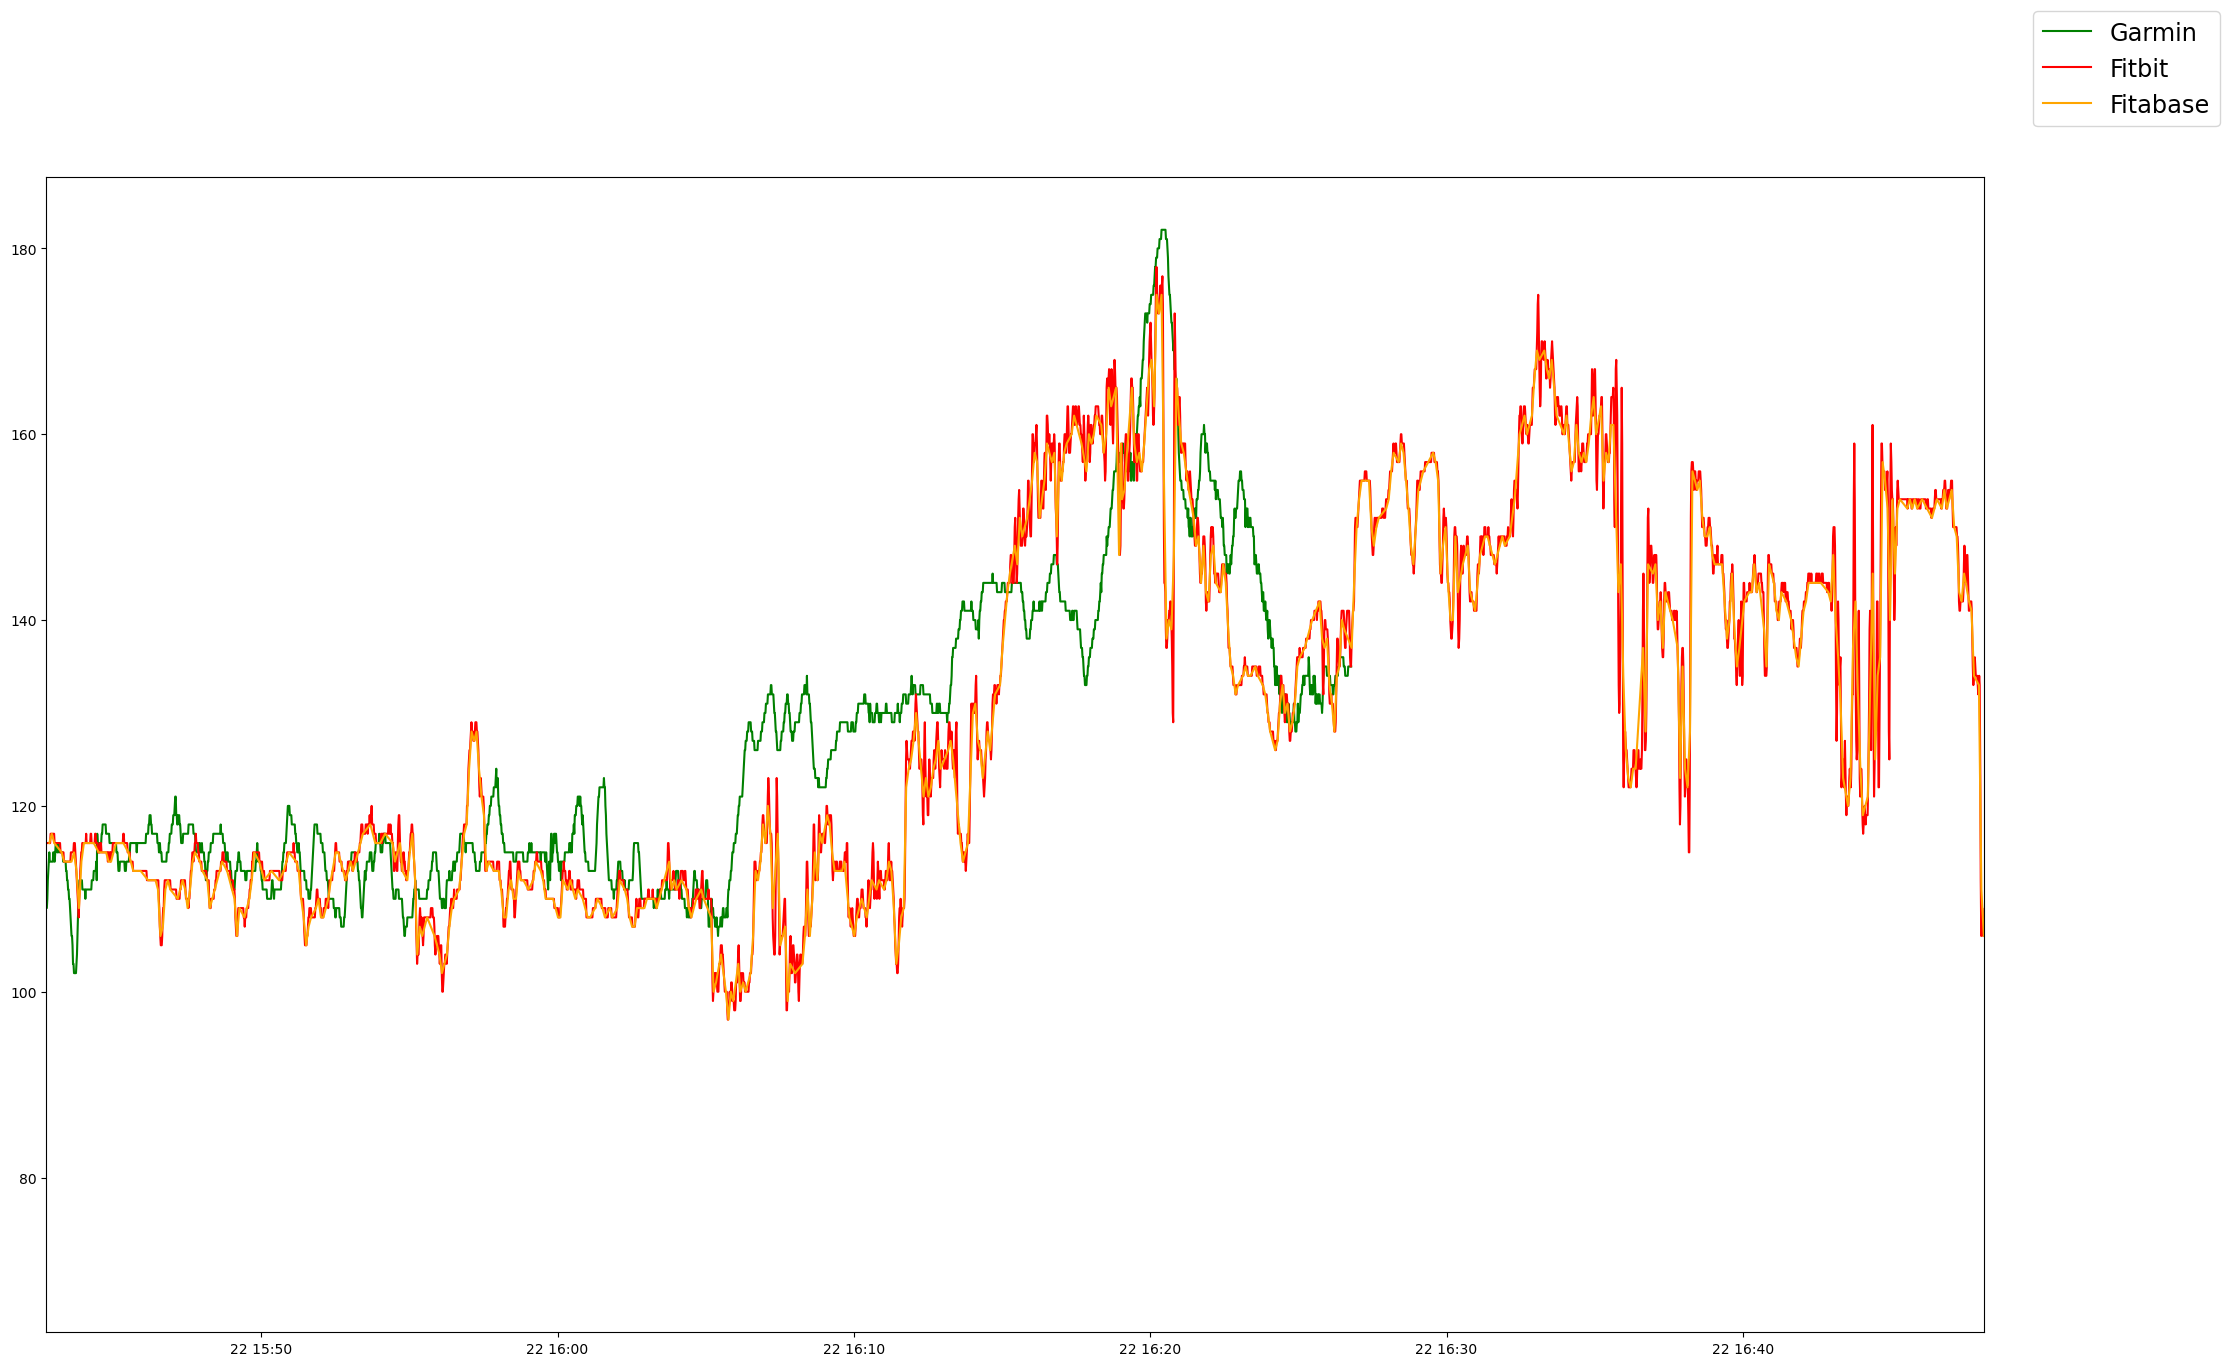

In [19]:
fig, ax = plt.subplots(figsize=[25, 15])
df1=garmin.loc[(garmin['record.timestamp[s]'] >= start+timedelta(minutes=14,seconds=0)) & (garmin['record.timestamp[s]'] < end), :].reset_index(drop=True)
df1['record.timestamp[s]'] = df1['record.timestamp[s]'].apply(lambda x: x - timedelta(minutes=21, seconds=20))
ax.plot(df1['record.timestamp[s]'], df1['record.heart_rate[bpm]'], label='Garmin', color='green')

ax.plot(slog_hr['Time'], slog_hr['Heart Rate'], label='Fitbit', color='red')

ax.plot(fitabase['Time'], fitabase['Value'], label='Fitabase', color='orange')
ax.set(xlim=[start, end])

# Format the x-axis as dates
ax.xaxis_date()

fig.legend(fontsize='xx-large')
plt.show()

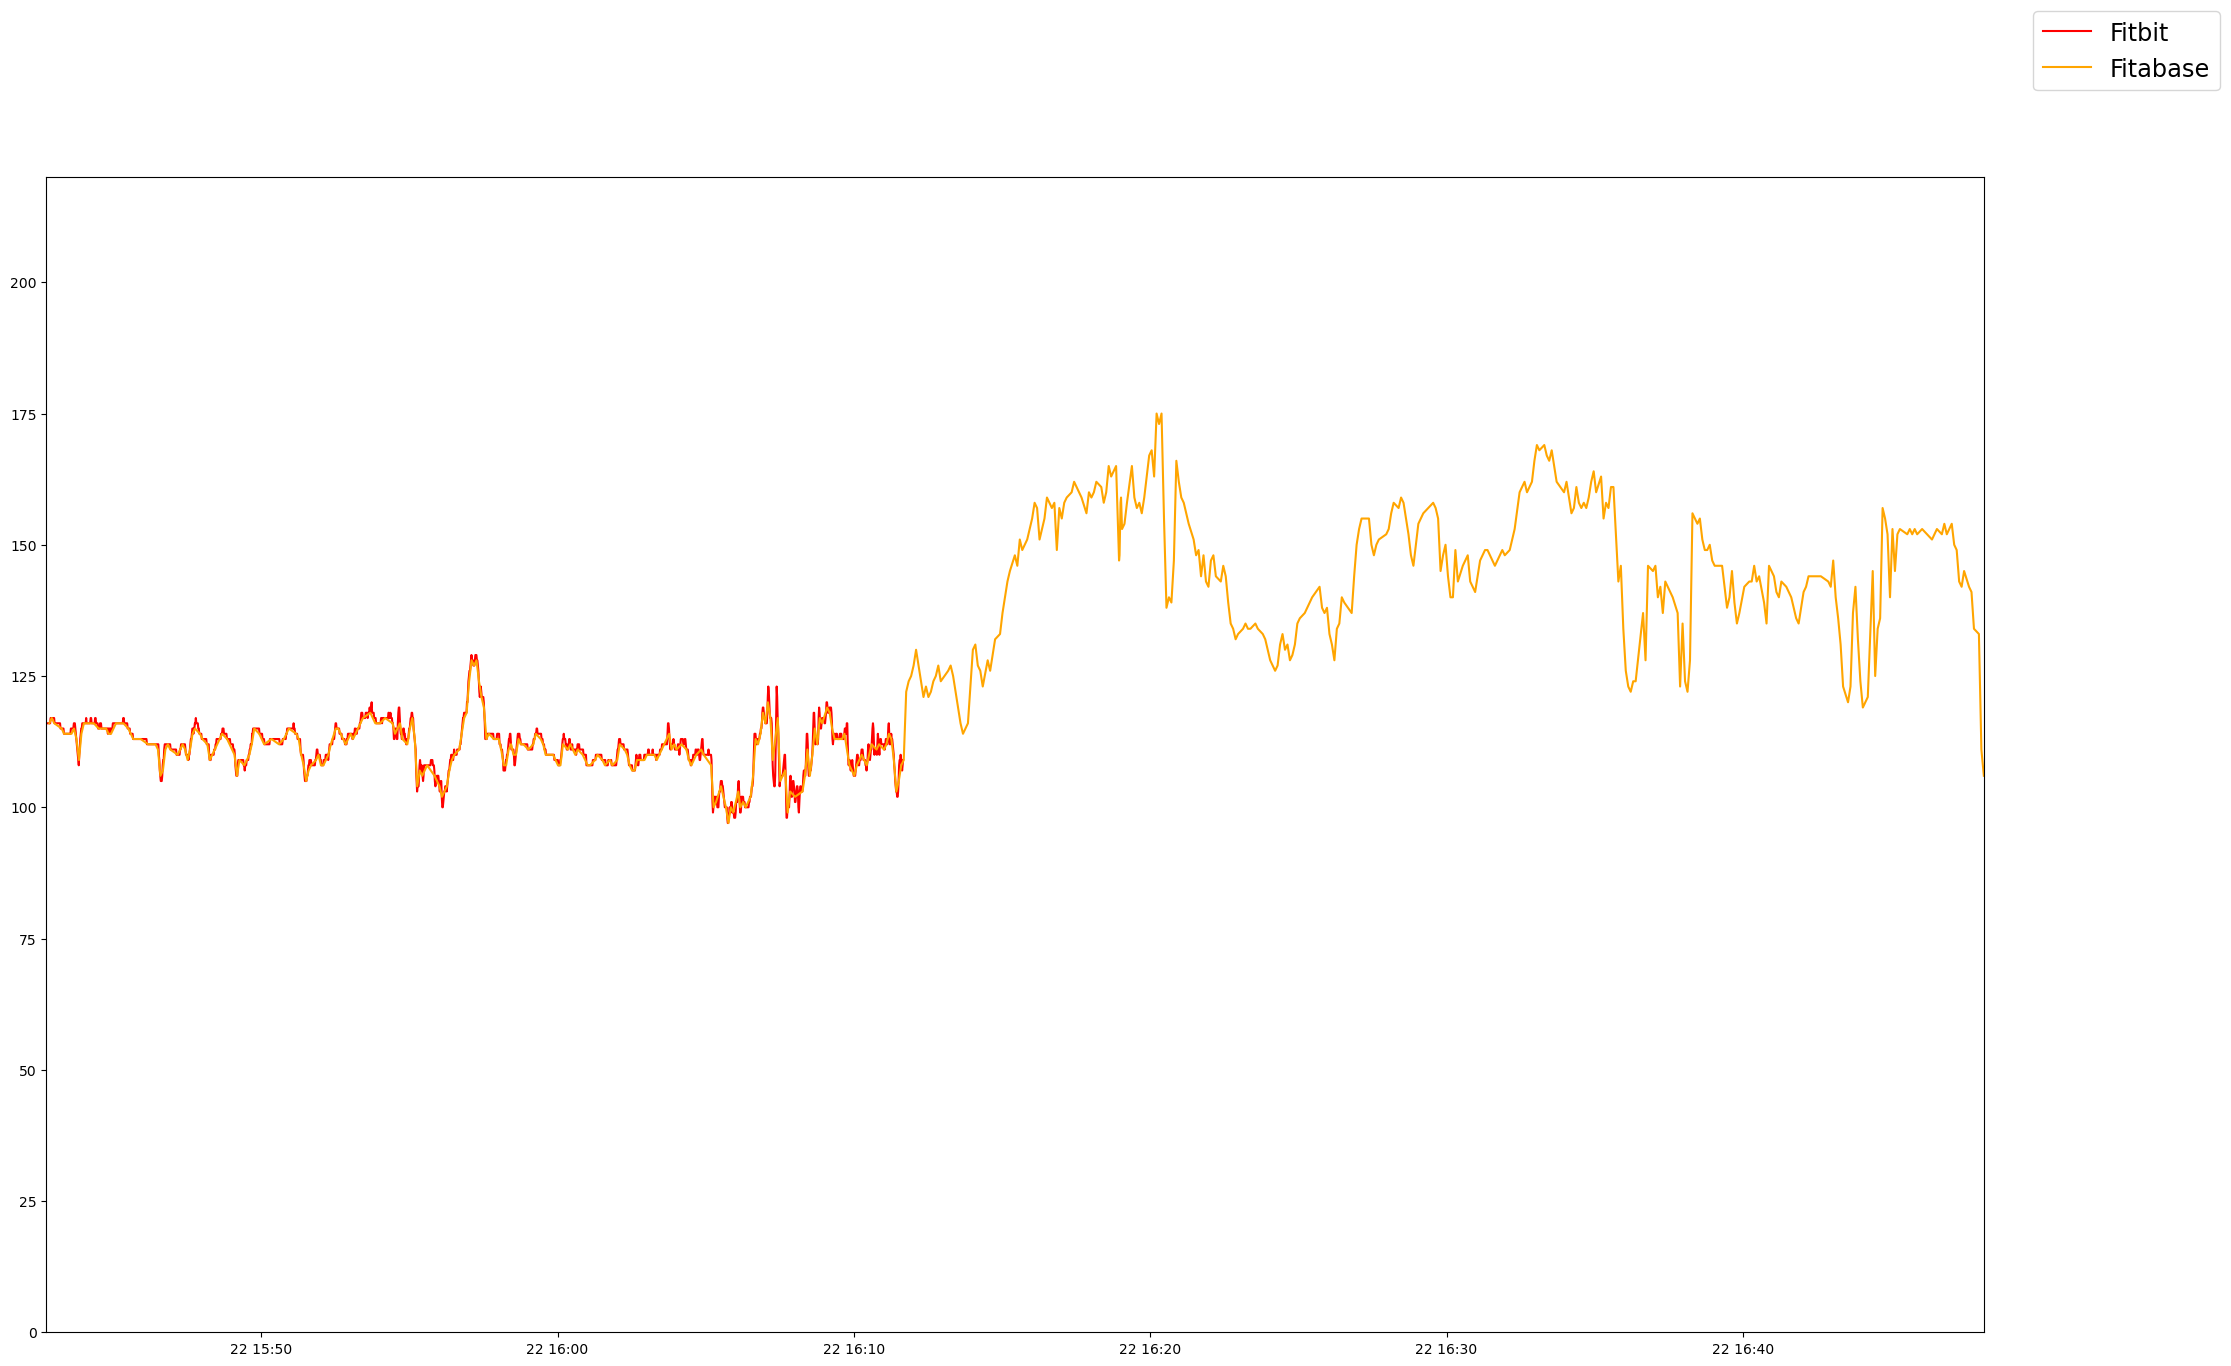

In [8]:


df1=slog_hr.loc[(slog_hr['Time'] >= start) & (slog_hr['Time'] < start+timedelta(hours=0,minutes=28, seconds=55)), :].reset_index(drop=True)

fig, ax = plt.subplots(figsize=[25,15])
ax.plot(df1['Time'], df1['Heart Rate'], label='Fitbit', color='red')
ax.plot(fitabase['Time'], fitabase['Value'], label='Fitabase', color='orange')
#ax.plot(actiheart['Time'], actiheart['Heart Rate'], label='Actiheart', color='blue')
ax.set(xlim=[start, end], ylim=[0,220])
fig.legend(fontsize='xx-large')
plt.show()

## The code block below attempts to align the fitbit and fitabase using the hr peaks.
<p>This doesn't always work. If it doesn't work you will then need to run the next code block. If it does work, skip to the very last code block</p>

Fitbit Max Occured: 2023-05-22 16:25:03.741000
Fitabase Max Occured: 2023-05-22 16:33:47


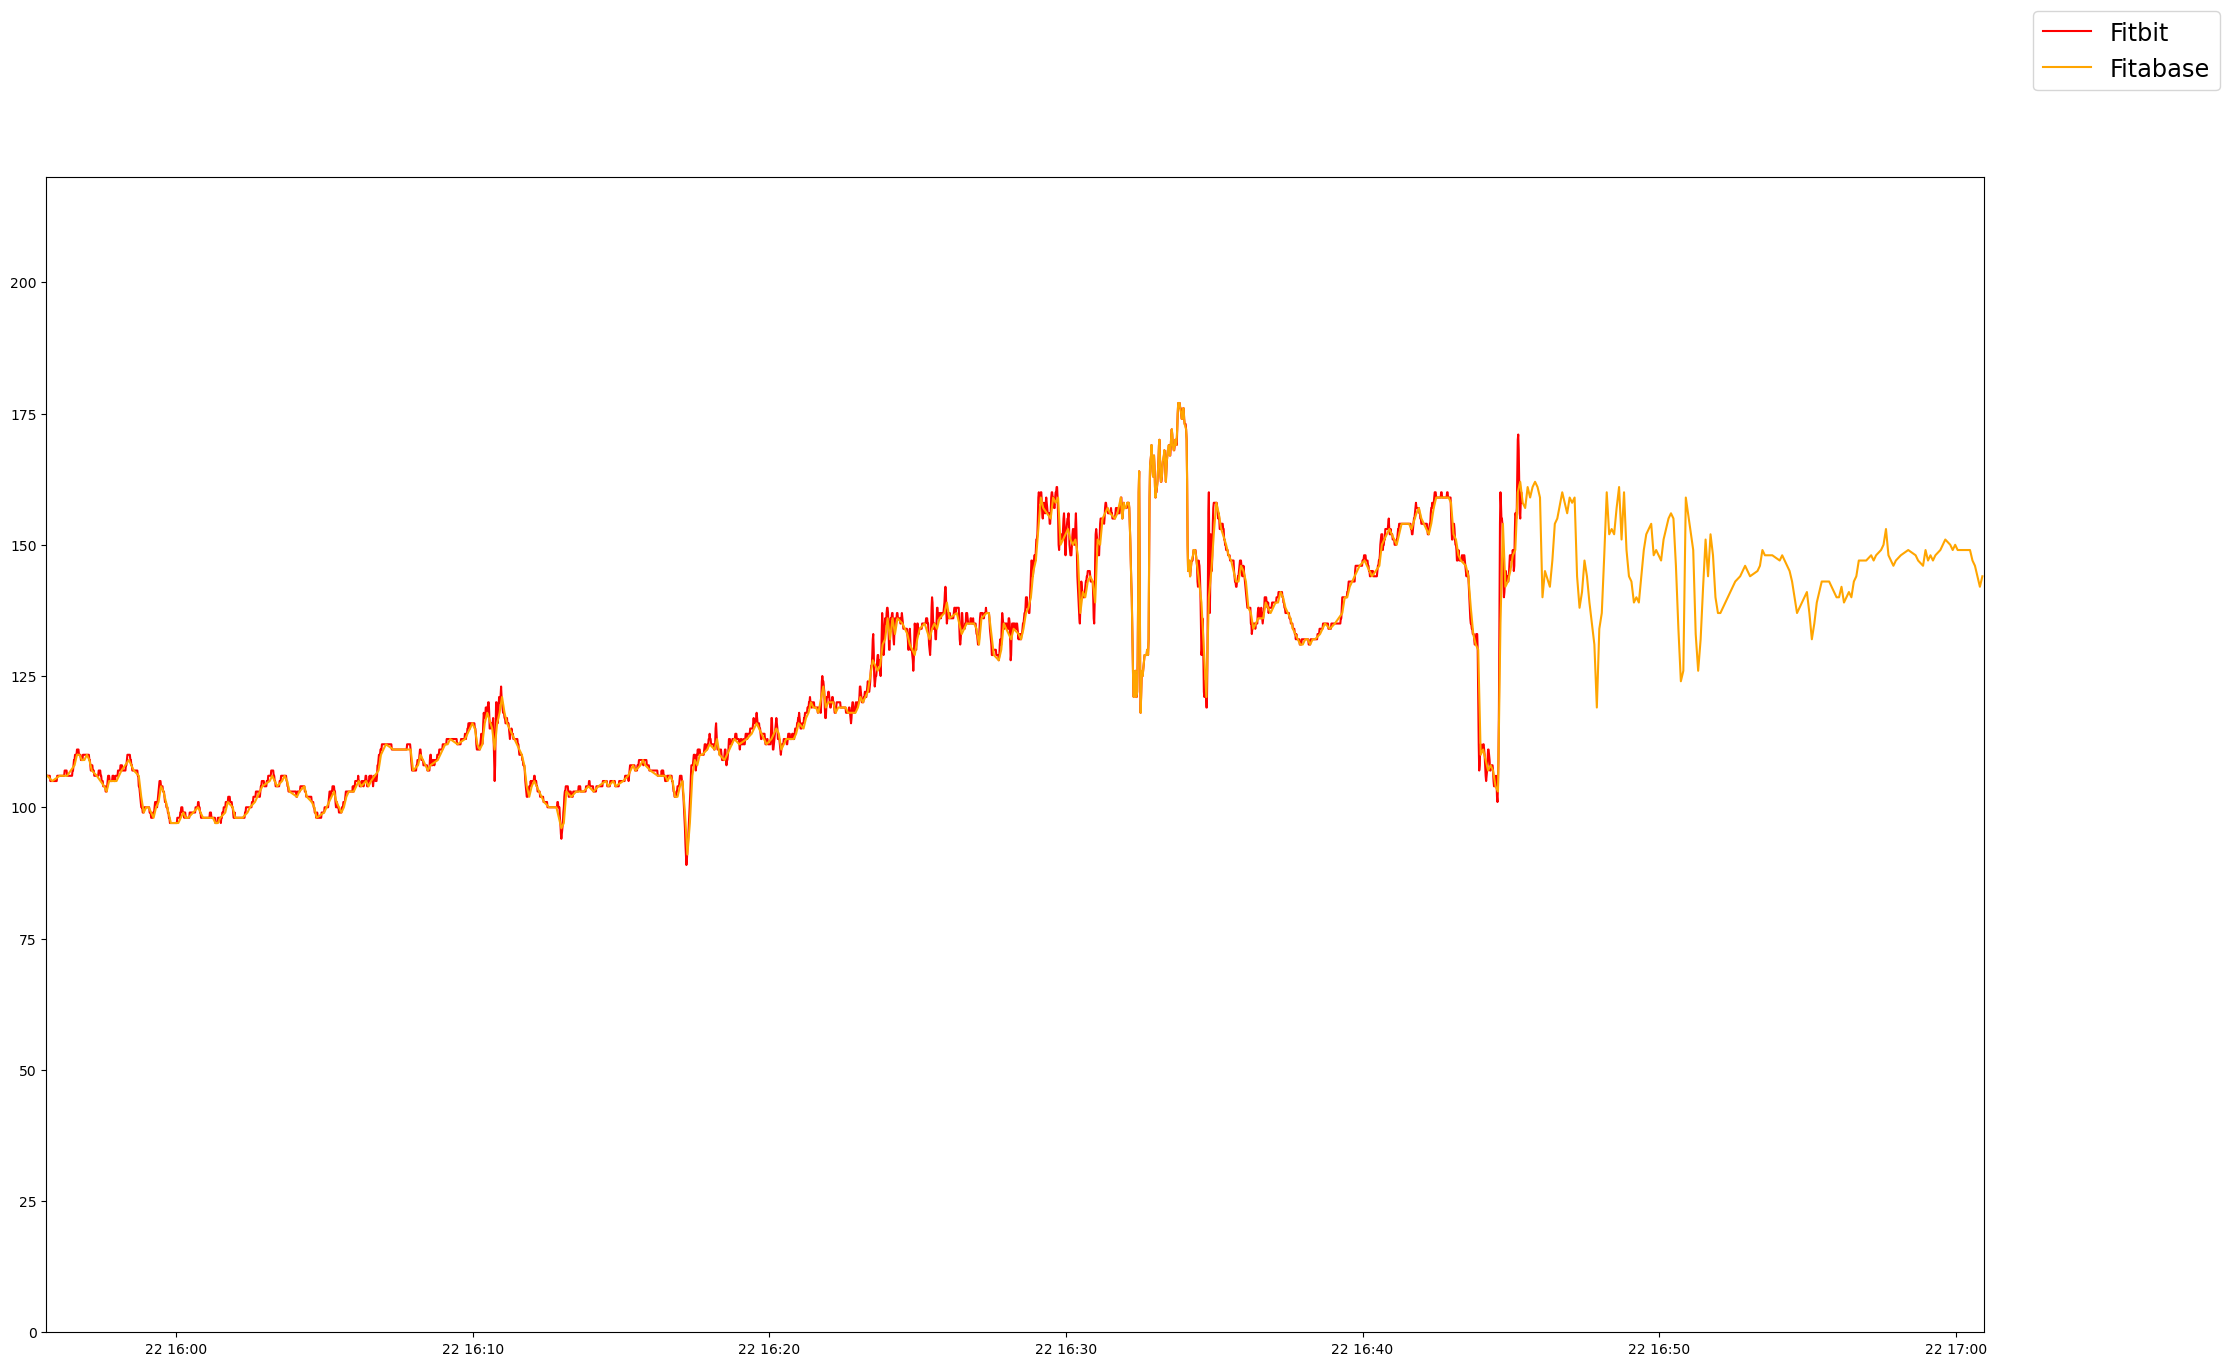

In [9]:
# OPTIONAL
# Align FITBIT with FITABASE
# First check when Max's occure
slog_max = slog_hr.iloc[slog_hr['Heart Rate'].idxmax(), 0]
fitabase_max = fitabase.iloc[fitabase['Value'].idxmax(), 0]
print(f"Fitbit Max Occured: {slog_max}\nFitabase Max Occured: {fitabase_max}")

# Shift data
if fitabase_max > slog_max :
    shift = fitabase_max - slog_max
    slog_hr['Time'] = slog_hr['Time'].apply(lambda x: x + shift)
else :
    shift = slog_max - fitabase_max
    slog_hr['Time'] = slog_hr['Time'].apply(lambda x: x - shift)

# Plot to check alignment
fig, ax = plt.subplots(figsize=[25,15])
ax.plot(slog_hr['Time'], slog_hr['Heart Rate'], label='Fitbit', color='red')
ax.plot(fitabase['Time'], fitabase['Value'], label='Fitabase', color='orange')
ax.set(xlim=[start, end], ylim=[0,220])
fig.legend(fontsize='xx-large')
plt.show()

## IF the above block did not align the fitbit and the fitabase, try the block below.
<p>You will once again need to change the first line of code. The first line of code is adding (or subtracting) some time to all the times in the fitbit time column. You can adjust whether your adding or subracting and how much time your adding/subtracting</p>

In [5]:
# Align Fitbit with Actiheart (Focus on aligning first rise)
slog_hr['Time'] = slog_hr['Time'].apply(lambda x: x - timedelta(minutes=1, seconds=0)) #### CHANGE THIS LINE OF CODE 

# Plot HR to check initial alignment
fig, ax = plt.subplots(figsize=[25,15])
ax.plot(slog_hr['Time'], slog_hr['Heart Rate'], label='Fitbit', color='red')
ax.plot(actiheart['Time'], actiheart['Heart Rate'], label='Actiheart', color='blue')
ax.set(xlim=[start, end], ylim=[0,220])
fig.legend(fontsize='xx-large')
plt.show()

## Run the last line of code to save the changes you've made to the fitbit heartrate file

In [25]:
# Write FITBIT data to CSV
df1.to_csv(path + "Fitbit data\\" + part_id+ "_heart.csv", index=None)